In [65]:
import numpy as np

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# MNIST
from keras.datasets import mnist

# plot
from matplotlib import pyplot as plt
%matplotlib inline  

from pathlib import Path

from PIL import Image


from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import backend as K

from joblib import Parallel, delayed

np.random.seed(123)  # for reproducibility

In [66]:
base_path = Path("data")
labels_path = base_path / "labels10k"
image_dirs = {
  "test": base_path / "teste",
  "train": base_path / "treinamento",
  "val": base_path / "validacao",
}

In [67]:
labels = {}
for label_file in labels_path.glob("*.txt"):
  with label_file.open("r") as file:
    labels[label_file.stem] = file.read().strip()

In [68]:
images = {key: [] for key in image_dirs}
for key, image_dir in image_dirs.items():
  images[key] = sorted(image_dir.glob("*.jpg"))

Labels (first 5): [('001953', '2RWRYW'), ('009192', 'BTC6AO'), ('008469', 'FQDU7M'), ('000304', 'QNV1HK'), ('004359', 'XP6QYA')]
Training images (first 5): [PosixPath('data/teste/009001.jpg'), PosixPath('data/teste/009002.jpg'), PosixPath('data/teste/009003.jpg'), PosixPath('data/teste/009004.jpg'), PosixPath('data/teste/009005.jpg')]


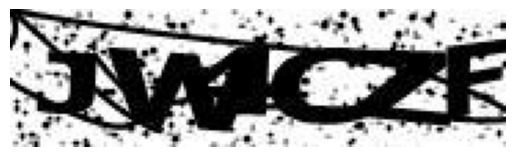

In [69]:
print("Labels (first 5):", list(labels.items())[:5])
print("Training images (first 5):", images["test"][:5])

image_path = images["test"][0]
image = Image.open(image_path)

# Display using matplotlib
plt.imshow(image)
plt.axis("off")  # Turn off axis labels
plt.show()

In [70]:
def split_image_into_subimages(image_path, num_splits=6, target_size=(28, 28)):
  image = Image.open(image_path)
  width, height = image.size
  sub_width = width // num_splits
  subimages = []

  for i in range(num_splits):
    left = i * sub_width
    right = (i + 1) * sub_width
    box = (left, 0, right, height)  # Crop region
    subimage = image.crop(box)
    subimage = subimage.convert("L")
    subimage = subimage.resize(target_size)  # Resize to target size
    subimages.append(np.array(subimage))  # Convert to NumPy array
  
  return subimages


In [71]:
digit_map = {str(i): i for i in range(10)}  # Mapping '0'-'9' to positions 0-9
letter_map = {chr(i): 10 + (i - ord('A')) for i in range(ord('A'), ord('Z') + 1)}  # Mapping 'A'-'Z' to positions 10-35

In [72]:
def encode_to_integer(label_part):
  """Converts a label part (digit or letter) into an integer representation."""
  if label_part.isdigit():
    return int(label_part)  # Return digit as integer
  elif label_part.isalpha():
    return ord(label_part.upper()) - ord('A') + 10  # Map 'A'-'Z' to 10-35
  return 0  # Default case, for robustness

In [73]:
def get_dataset(image_paths, labels):
  X = []
  y = []
  y_original = []

  for image_path in image_paths:
    # Extract the image ID (e.g., "000001" from "000001.jpg")
    image_id = image_path.stem

    # Skip if the label for this image ID is missing
    if image_id not in labels:
      continue

    # Get the label and split it into characters
    label = labels[image_id]
    label_parts = list(label)

    if (len(label) != 6):
      continue

    subimages = split_image_into_subimages(image_path, len(label))

    X.extend(subimages)  
    y.extend([encode_to_integer(part) for part in label_parts]) 
    y_original.extend(label_parts)

  return np.array(X), np.array(y), np.array(y_original)

In [74]:
X_train, y_train, y_original_train = get_dataset(images["train"], labels)
X_test, y_test, y_original_test = get_dataset(images["test"], labels)
X_val, y_val, y_original_val = get_dataset(images["val"], labels)

In [75]:
Y_train = to_categorical(y_train, 36)
Y_test = to_categorical(y_test, 36)
Y_val = to_categorical(y_val, 36)

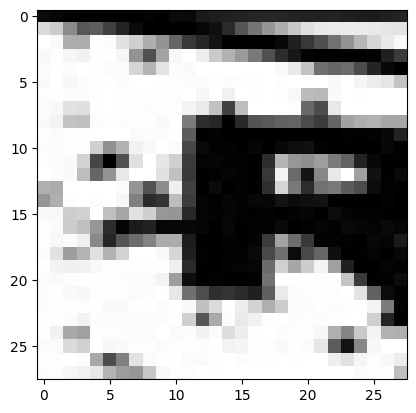

In [76]:
image = X_train[0]
plt.imshow(image, cmap="gray")

In [77]:
def calculate_gradient(channel):
	"""
	Computes the gradient of a 2D array (channel) along rows and columns.

	Parameters:
			channel (ndarray): Input 2D array.

	Returns:
			tuple: Gradients along rows (g_row) and columns (g_col).
	"""
	# Initialize gradients with the same shape and data type as the input
	g_row = np.zeros_like(channel)
	g_col = np.zeros_like(channel)

	# Compute gradients along rows (central difference)
	g_row[1:-1, :] = channel[2:, :] - channel[:-2, :]

	# Compute gradients along columns (central difference)
	g_col[:, 1:-1] = channel[:, 2:] - channel[:, :-2]

	return g_row, g_col

In [78]:
def _hog_normalize_block(block, eps=1e-5):
	out = block / np.sqrt(np.sum(block**2) + eps**2)
	out = np.minimum(out, 0.2)
	out = out / np.sqrt(np.sum(out**2) + eps**2)

	return out


In [79]:
import _hog_puro

def calculate_hog_image(image, orientations=9, pixels_per_cell=(4, 4)):
	"""
	Calculate the Histogram of Oriented Gradients (HOG) for a given image.
	
	Parameters:
			image (numpy.ndarray): Input image.
			orientations (int): Number of orientation bins.
			pixels_per_cell (tuple): Size (in pixels) of a cell.
			cells_per_block (tuple): Number of cells in each block.
	
	Returns:
			numpy.ndarray: HOG image.
	"""

	image = image.astype(np.float64, copy=False)

	# Calculate the gradient magnitude and direction
	Gx, Gy = calculate_gradient(image)

	img_width, img_height = image.shape
	cell_size_x, cell_size_y = pixels_per_cell
	hog_width, hog_height = (img_width // cell_size_x, img_height // cell_size_y)

	hog_image = np.zeros((hog_width, hog_height, orientations), dtype=np.float64)

	Gx = Gx.astype(float, copy=False)
	Gy = Gy.astype(float, copy=False)

	_hog_puro.hog_histograms(Gy, Gx,
																cell_size_x, cell_size_y,
																img_width, img_height,
																int(hog_width), int(hog_height),
																orientations, hog_image)
	

	# Normalize the HOG image
	n_blocks_row = (hog_height - 1) + 1
	n_blocks_col = (hog_width - 1) + 1

	normalized_blocks = np.zeros(
			(n_blocks_row, n_blocks_col, 1, 1, orientations), dtype=np.float64
	)

	for r in range(n_blocks_row):
			for c in range(n_blocks_col):
					block = hog_image[r : r + 1, c : c + 1, :]
					normalized_blocks[r, c, :] = _hog_normalize_block(block)

	normalized_blocks = normalized_blocks.ravel()

	return normalized_blocks

In [80]:
def get_hog_features(image):
  hog_image = calculate_hog_image(image, orientations=9, pixels_per_cell=(4, 4))

  return hog_image


In [81]:
X_hog_train = np.array(
    Parallel(n_jobs=-1)(delayed(get_hog_features)(image) for image in X_train)
)

scaler = MinMaxScaler()
X_hog_train = scaler.fit_transform(X_hog_train)
print(X_hog_train.shape)

X_hog_test = np.array(
    Parallel(n_jobs=-1)(delayed(get_hog_features)(image) for image in X_test)
)

scaler = MinMaxScaler()
X_hog_test = scaler.fit_transform(X_hog_test)
print(X_hog_test.shape)

X_hog_val = np.array(
    Parallel(n_jobs=-1)(delayed(get_hog_features)(image) for image in X_val)
)

scaler = MinMaxScaler()
X_hog_val = scaler.fit_transform(X_hog_val)
print(X_hog_val.shape)

(47982, 441)
(5994, 441)
(5994, 441)


In [82]:
K.clear_session()
# Sequential layer
model = Sequential()

In [83]:
# fully connected layer
model.add(Dense(441, activation='relu', input_shape=(441,)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(36, activation='softmax'))

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 441)               194922    
                                                                 
 dropout (Dropout)           (None, 441)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               56576     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 36)                2

In [85]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [86]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=20,    
    restore_best_weights=True 
)

In [87]:
response = model.fit(
  X_hog_train, Y_train, 
  validation_data=(X_hog_val, Y_val), 
  batch_size=128, 
  epochs=400,
  verbose=1,
  callbacks=[early_stopping]
)

Epoch 1/400
375/375 [==============================] - 3s 5ms/step - loss: 2.2640 - accuracy: 0.3192 - val_loss: 1.4793 - val_accuracy: 0.5235
Epoch 2/400
375/375 [==============================] - 2s 5ms/step - loss: 1.4417 - accuracy: 0.5320 - val_loss: 1.2820 - val_accuracy: 0.5838
Epoch 3/400
375/375 [==============================] - 2s 4ms/step - loss: 1.2477 - accuracy: 0.5875 - val_loss: 1.1713 - val_accuracy: 0.6216
Epoch 4/400
375/375 [==============================] - 2s 5ms/step - loss: 1.1123 - accuracy: 0.6315 - val_loss: 1.0785 - val_accuracy: 0.6491
Epoch 5/400
375/375 [==============================] - 2s 5ms/step - loss: 1.0157 - accuracy: 0.6614 - val_loss: 1.0549 - val_accuracy: 0.6623
Epoch 6/400
375/375 [==============================] - 2s 5ms/step - loss: 0.9369 - accuracy: 0.6874 - val_loss: 1.0293 - val_accuracy: 0.6657
Epoch 7/400
375/375 [==============================] - 2s 5ms/step - loss: 0.8705 - accuracy: 0.7072 - val_loss: 1.0280 - val_accuracy: 0.6665

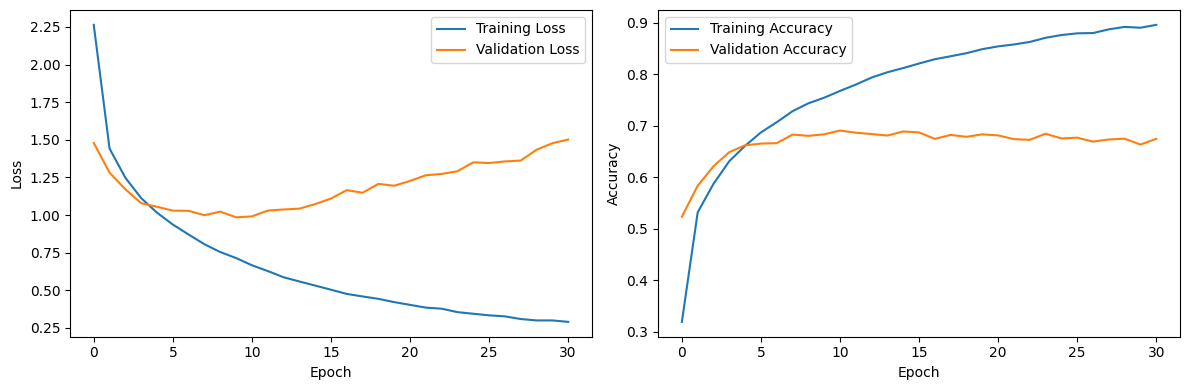

In [88]:
train_loss = response.history['loss']
train_accuracy = response.history['accuracy']
val_loss = response.history['val_loss']
val_accuracy = response.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
score = model.evaluate(X_hog_test, Y_test, verbose=1)

188/188 [==============================] - 0s 2ms/step - loss: 0.9847 - accuracy: 0.6864


In [90]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.9846668243408203, 0.6863530278205872]


In [91]:
def evaluate_captcha_accuracy(model, X_test, y_test, captcha_length=6):
  """
  Evaluate the model's accuracy on entire CAPTCHAs.

  Args:
    model: Trained model for character recognition.
    X_test: Test dataset (images split into subimages).
    y_test: Test labels (one-hot encoded).
    captcha_length: Number of characters per CAPTCHA.

  Returns:
    accuracy_by_length: List of accuracies by the number of correct characters per CAPTCHA.
  """
  # Convert one-hot encoded labels back to characters
  def decode_label(one_hot_vector):
    index = np.argmax(one_hot_vector)
    if index < 10:
      return str(index)
    else:
      return chr(ord('A') + (index - 10))

  total_captchas = len(X_test) // captcha_length
  correct_captchas_by_length = [0] * (captcha_length + 1)

  for i in range(total_captchas):
    # Extract the subimages and ground truth for one CAPTCHA
    start_idx = i * captcha_length
    end_idx = start_idx + captcha_length
    subimages = X_test[start_idx:end_idx]
    true_labels = y_test[start_idx:end_idx]

    # Predict the labels for the subimages
    predictions = model.predict(subimages)
    predicted_labels = [decode_label(pred) for pred in predictions]

    # Decode true labels
    true_labels_decoded = [decode_label(true) for true in true_labels]

    # Count correct predictions for this CAPTCHA
    correct_count = sum(
      pred == true for pred, true in zip(predicted_labels, true_labels_decoded)
    )

    # Update statistics
    for j in range(correct_count+1):
      correct_captchas_by_length[j] += 1

  # Calculate accuracy by number of correct characters
  accuracy_by_length = [
    correct_captchas / total_captchas for correct_captchas in correct_captchas_by_length
  ]

  return accuracy_by_length

In [92]:
accuracy_by_length = evaluate_captcha_accuracy(model, X_hog_test, Y_test)
for num_correct, accuracy in enumerate(accuracy_by_length):
    print(f"Accuracy for CAPTCHAs with {num_correct} correct characters: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 14ms/step
Accuracy for CAPTCHAs with 0 correct characters: 100.00%
Accuracy for CAPTCHAs with 1 correct characters: 99.70%
Accuracy for CAPTCHAs with 2 correct characters: 97.70%
Accuracy for CAPTCHAs with 3 correct characters: 91.39%
Accuracy for CAPTCHAs with 4 correct characters: 70.87%
Accuracy for CAPTCHAs with 5 correct characters: 40.84%
Accuracy for CAPTCHAs with 6 correct characters: 11.31%


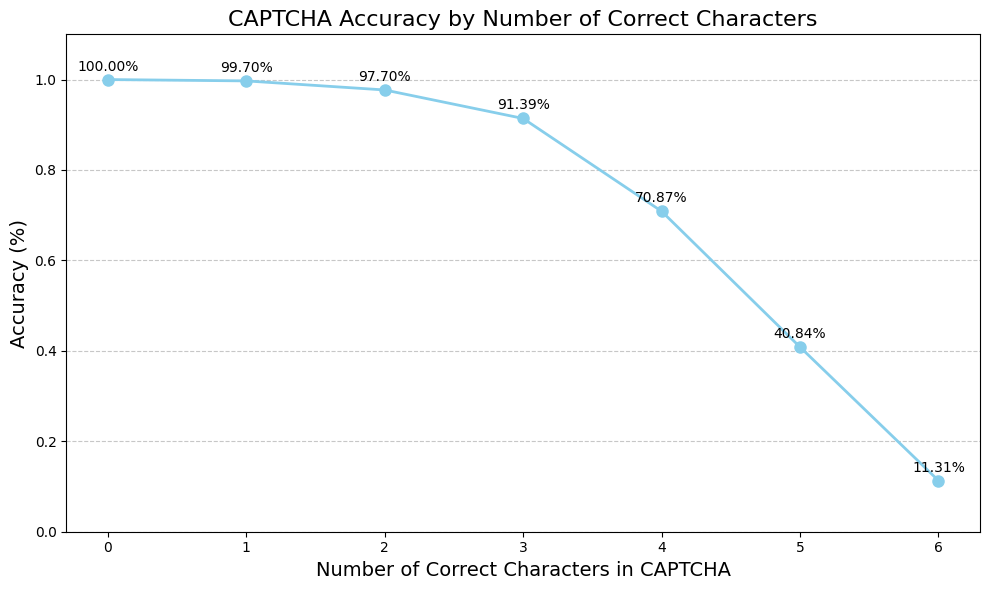

In [93]:
num_correct_chars = np.arange(len(accuracy_by_length))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(num_correct_chars, accuracy_by_length, marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)

# Add labels and title
plt.xlabel("Number of Correct Characters in CAPTCHA", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("CAPTCHA Accuracy by Number of Correct Characters", fontsize=16)

# Display percentage values next to points
for i, accuracy in enumerate(accuracy_by_length):
    plt.text(i, accuracy + 0.02, f"{accuracy * 100:.2f}%", ha='center', fontsize=10)

# Set y-axis to percentage
plt.ylim(0, 1.1)  # Accuracy is between 0 and 1; slightly above for text placement
plt.xticks(num_correct_chars)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [94]:
def get_captcha_recognition(image_path):
  subimages = split_image_into_subimages(image_path)

  hog_subimages = np.array(
    Parallel(n_jobs=-1)(delayed(get_hog_features)(image) for image in subimages)
  )

  scaler = MinMaxScaler()
  hog_subimages = scaler.fit_transform(hog_subimages)

  predictions = model.predict(hog_subimages)
  predicted_labels = [np.argmax(pred) for pred in predictions]
  return "".join([chr(ord('A') + idx - 10) if idx >= 10 else str(idx) for idx in predicted_labels])

In [95]:
num_images = 3
predictions = []

for i in range(num_images):
  predictions.append(get_captcha_recognition(images['test'][i]))

1/1 [==============================] - 0s 15ms/step


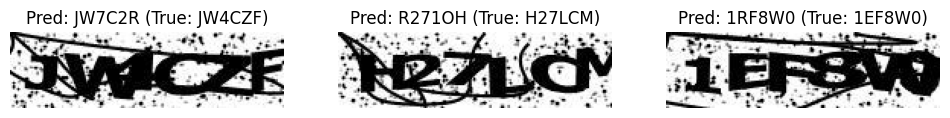

In [96]:
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i in range(num_images):
  image = Image.open(images['test'][i])
  axes[i].imshow(image)
  axes[i].axis('off')
  axes[i].set_title(f"Pred: {predictions[i]} (True: {labels[images['test'][i].stem]})")